# ==========================================
# Mini Project: Phân Cụm Khách Hàng Dựa Trên Luật Kết Hợp
# ==========================================


In [2]:
# ------------------------------------------
# Parameters
# ------------------------------------------

# Input paths
CLEANED_DATA_PATH = "../data/processed/cleaned_uk_data.csv"
RULES_INPUT_PATH = "../data/processed/rules_apriori_filtered.csv"

# Rule selection criteria
TOP_K_RULES = 150
SORT_RULES_BY = "lift"  # lift | confidence | support
MIN_ANTECEDENT_LEN = 2  # Lọc luật có ít nhất 2 items trong antecedent
MIN_LIFT_THRESHOLD = 2.0  # Chỉ lấy luật có lift >= 2.0

# Clustering parameters
K_MIN = 2
K_MAX = 10
RANDOM_STATE = 42

# Output
OUTPUT_DIR = "data/processed"
COMPARISON_OUTPUT = "data/processed/variant_comparison.csv"

In [3]:
# ------------------------------------------
# Setup
# ------------------------------------------
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Setup paths
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from cluster_library import RuleBasedCustomerClusterer

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Setup completed")

✓ Setup completed


C:\Users\Mr Vinh\AppData\Local\Temp\ipykernel_17816\2951945756.py:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])


Loaded 485,123 transactions from 3,921 customers
Customer × Item matrix: (3921, 4007)

Total rules available: 1,794
✓ Calculated antecedent_len
✓ Calculated consequent_len
After filtering (lift>=2.0, antecedent_len>=2): 923
Selected top 150 rules by lift

TOP 10 LUẬT TIÊU BIỂU


,antecedents_str,consequents_str,support,confidence,lift,antecedent_len
0,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010932,0.951691,74.567045,2
1,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010599,0.955000,74.502403,2
2,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER PARSLEY,0.010432,0.940000,74.297105,2
3,"HERB MARKER PARSLEY, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010932,0.951691,74.244244,2
4,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010710,0.950739,74.169983,2
5,"HERB MARKER BASIL, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010710,0.936893,73.407619,2
6,"HERB MARKER MINT, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010599,0.931707,73.001294,2
7,"HERB MARKER MINT, HERB MARKER ROSEMARY",HERB MARKER PARSLEY,0.010488,0.921951,72.870539,2
8,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER PARSLEY,0.010377,0.921182,72.809761,2
11,"HERB MARKER ROSEMARY, HERB MARKER THYME",HERB MARKER PARSLEY,0.010932,0.920561,72.760637,2


c:\Users\Mr Vinh\.conda\envs\shopping_env\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\Mr Vinh\.conda\envs\shopping_env\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\Mr Vinh\.conda\envs\shopping_env\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


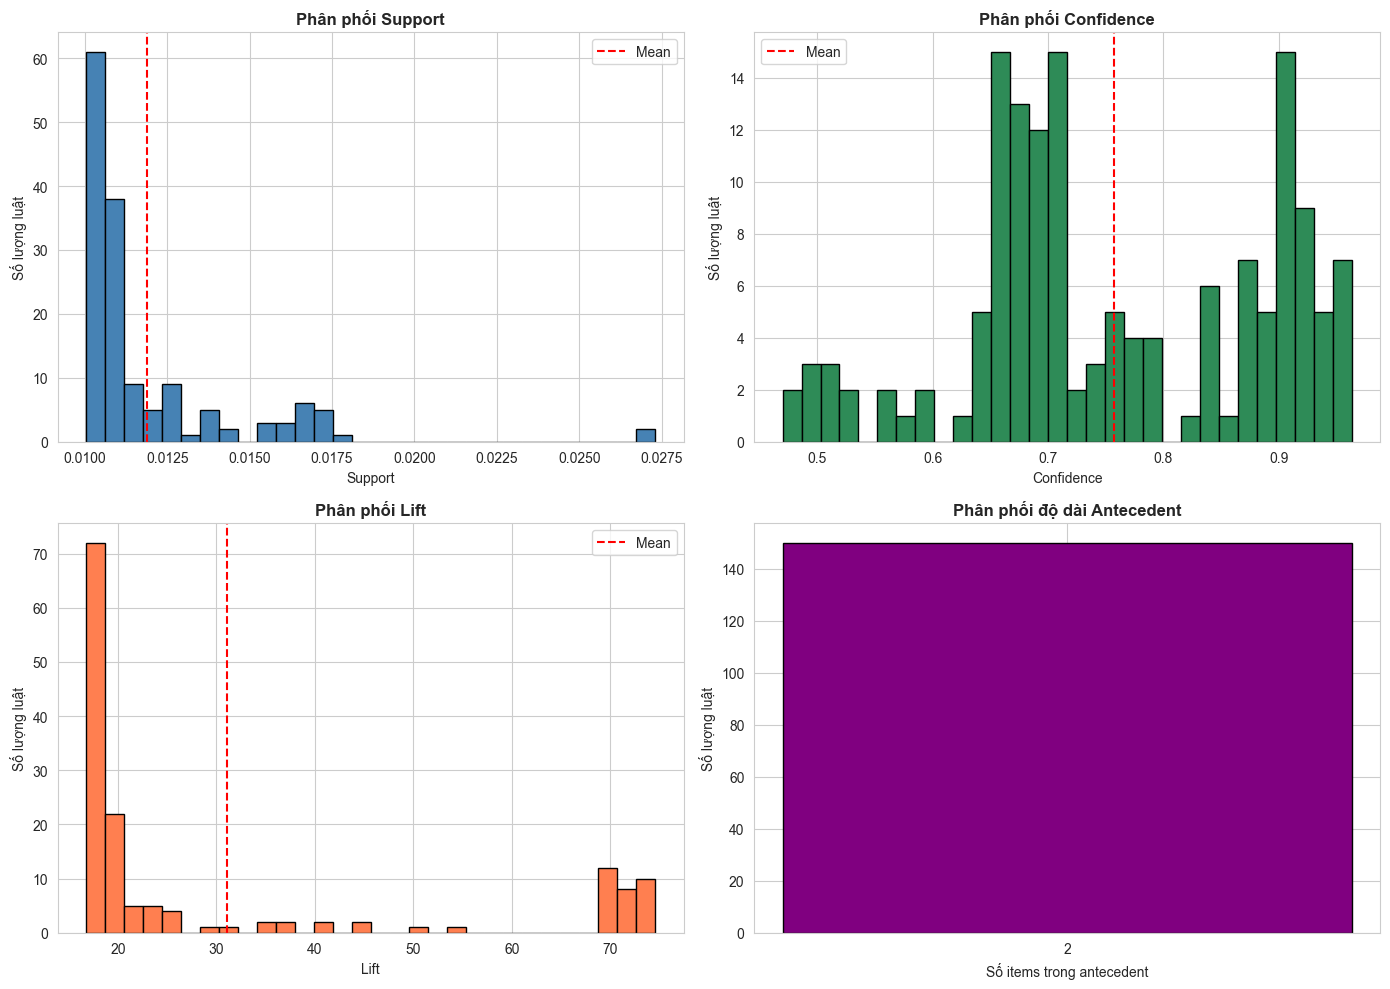


📊 Thống kê luật đã chọn:
  • Support: 0.0100 - 0.0273 (mean: 0.0119)
  • Confidence: 0.4697 - 0.9632 (mean: 0.7575)
  • Lift: 16.77 - 74.57 (mean: 31.06)


In [5]:
# ------------------------------------------
# YÊU CẦU 1: Chọn và Trình Bày Luật Kết Hợp
# ------------------------------------------
# Tiêu chí lựa chọn:
# - Top K: 150 luật
# - Sắp xếp theo: Lift (ưu tiên luật có mối liên hệ mạnh)
# - Lọc: 
#   - Min antecedent length = 2 (loại bỏ luật đơn giản)
#   - Min lift >= 2.0 (đảm bảo luật có ý nghĩa thống kê)

# Load cleaned data
df_clean = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])
print(f"Loaded {df_clean.shape[0]:,} transactions from {df_clean['CustomerID'].nunique():,} customers")

# Initialize clusterer
clusterer = RuleBasedCustomerClusterer(df_clean=df_clean)
customer_item_bool = clusterer.build_customer_item_matrix(threshold=1)
print(f"Customer × Item matrix: {customer_item_bool.shape}")

# Load and filter rules
# Load and filter rules
rules_raw = pd.read_csv(RULES_INPUT_PATH)
print(f"\nTotal rules available: {len(rules_raw):,}")

# Tính toán antecedent_len và consequent_len nếu chưa có
if 'antecedent_len' not in rules_raw.columns:
    rules_raw['antecedent_len'] = rules_raw['antecedents'].apply(
        lambda x: len(eval(x)) if isinstance(x, str) else len(x)
    )
    print("✓ Calculated antecedent_len")

if 'consequent_len' not in rules_raw.columns:
    rules_raw['consequent_len'] = rules_raw['consequents'].apply(
        lambda x: len(eval(x)) if isinstance(x, str) else len(x)
    )
    print("✓ Calculated consequent_len")

# Apply filtering criteria
rules_filtered = rules_raw[
    (rules_raw['lift'] >= MIN_LIFT_THRESHOLD) &
    (rules_raw['antecedent_len'] >= MIN_ANTECEDENT_LEN)
].copy()

print(f"After filtering (lift>={MIN_LIFT_THRESHOLD}, antecedent_len>={MIN_ANTECEDENT_LEN}): {len(rules_filtered):,}")

# Sort and select top K
rules_filtered = rules_filtered.sort_values(SORT_RULES_BY, ascending=False).head(TOP_K_RULES)
print(f"Selected top {TOP_K_RULES} rules by {SORT_RULES_BY}")

# Display top 10 representative rules
print("\n" + "="*80)
print("TOP 10 LUẬT TIÊU BIỂU")
print("="*80)
display_cols = ['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift', 'antecedent_len']
display(rules_filtered[display_cols].head(10))

# Visualize rule statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Support distribution
axes[0,0].hist(rules_filtered['support'], bins=30, color='steelblue', edgecolor='black')
axes[0,0].set_title('Phân phối Support', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Support')
axes[0,0].set_ylabel('Số lượng luật')
axes[0,0].axvline(rules_filtered['support'].mean(), color='red', linestyle='--', label='Mean')
axes[0,0].legend()

# Confidence distribution
axes[0,1].hist(rules_filtered['confidence'], bins=30, color='seagreen', edgecolor='black')
axes[0,1].set_title('Phân phối Confidence', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Confidence')
axes[0,1].set_ylabel('Số lượng luật')
axes[0,1].axvline(rules_filtered['confidence'].mean(), color='red', linestyle='--', label='Mean')
axes[0,1].legend()

# Lift distribution
axes[1,0].hist(rules_filtered['lift'], bins=30, color='coral', edgecolor='black')
axes[1,0].set_title('Phân phối Lift', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Lift')
axes[1,0].set_ylabel('Số lượng luật')
axes[1,0].axvline(rules_filtered['lift'].mean(), color='red', linestyle='--', label='Mean')
axes[1,0].legend()

# Antecedent length distribution
ant_len_counts = rules_filtered['antecedent_len'].value_counts().sort_index()
axes[1,1].bar(ant_len_counts.index, ant_len_counts.values, color='purple', edgecolor='black')
axes[1,1].set_title('Phân phối độ dài Antecedent', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Số items trong antecedent')
axes[1,1].set_ylabel('Số lượng luật')
axes[1,1].set_xticks(ant_len_counts.index)

plt.tight_layout()
plt.show()

print(f"\n📊 Thống kê luật đã chọn:")
print(f"  • Support: {rules_filtered['support'].min():.4f} - {rules_filtered['support'].max():.4f} (mean: {rules_filtered['support'].mean():.4f})")
print(f"  • Confidence: {rules_filtered['confidence'].min():.4f} - {rules_filtered['confidence'].max():.4f} (mean: {rules_filtered['confidence'].mean():.4f})")
print(f"  • Lift: {rules_filtered['lift'].min():.2f} - {rules_filtered['lift'].max():.2f} (mean: {rules_filtered['lift'].mean():.2f})")

In [6]:
# ------------------------------------------
# YÊU CẦU 2: Feature Engineering - 2 Biến Thể
# ------------------------------------------
# Variant 1: Binary Rules (Baseline)
# - Mỗi luật = 1 feature nhị phân (0/1)
# - Khách hàng "bật" feature nếu thỏa antecedent của luật
# - Không có trọng số, không có RFM
#
# Variant 2: Weighted Rules + RFM (Advanced)
# - Mỗi luật có trọng số = lift × confidence
# - Ghép thêm 3 features RFM (Recency, Frequency, Monetary)
# - RFM được chuẩn hóa (StandardScaler)
# - Rule features cũng được scale

# Prepare rules for clusterer
rules_filtered.to_csv('temp_filtered_rules.csv', index=False)
rules_df = clusterer.load_rules(
    rules_csv_path='temp_filtered_rules.csv',
    top_k=TOP_K_RULES,
    sort_by=SORT_RULES_BY,
)

print(f"✓ Loaded {len(rules_df)} rules for feature engineering")

# VARIANT 1: Binary Rules Only (Baseline)
print("\n" + "="*80)
print("VARIANT 1: BINARY RULES (BASELINE)")
print("="*80)

X_v1, meta_v1 = clusterer.build_final_features(
    weighting="none",           # No weighting
    use_rfm=False,              # No RFM
    rfm_scale=False,
    rule_scale=False,           # No scaling
    min_antecedent_len=MIN_ANTECEDENT_LEN,
)

print(f"Features shape: {X_v1.shape}")
print(f"  • {X_v1.shape[1]} binary rule features")
print(f"  • {X_v1.shape[0]} customers")
print(f"\nFeature statistics:")
print(f"  • Mean activation: {X_v1.mean():.4f}")
print(f"  • Sparsity: {(X_v1 == 0).sum().sum() / X_v1.size:.2%}")

# VARIANT 2: Weighted Rules + RFM (Advanced)
print("\n" + "="*80)
print("VARIANT 2: WEIGHTED RULES + RFM (ADVANCED)")
print("="*80)

X_v2, meta_v2 = clusterer.build_final_features(
    weighting="lift_x_conf",    # Weight by lift × confidence
    use_rfm=True,               # Include RFM
    rfm_scale=True,             # Scale RFM
    rule_scale=True,            # Scale rule features
    min_antecedent_len=MIN_ANTECEDENT_LEN,
)

print(f"Features shape: {X_v2.shape}")
print(f"  • {X_v2.shape[1] - 3} weighted rule features")
print(f"  • 3 RFM features (scaled)")
print(f"  • {X_v2.shape[0]} customers")

# Show RFM statistics
if 'Recency' in meta_v2.columns:
    print(f"\nRFM Statistics:")
    print(f"  • Recency: {meta_v2['Recency'].mean():.1f} ± {meta_v2['Recency'].std():.1f} days")
    print(f"  • Frequency: {meta_v2['Frequency'].mean():.1f} ± {meta_v2['Frequency'].std():.1f} transactions")
    print(f"  • Monetary: £{meta_v2['Monetary'].mean():.2f} ± £{meta_v2['Monetary'].std():.2f}")

✓ Loaded 150 rules for feature engineering

VARIANT 1: BINARY RULES (BASELINE)
Features shape: (3921, 150)
  • 150 binary rule features
  • 3921 customers

Feature statistics:
  • Mean activation: 0.0216
  • Sparsity: 97.84%

VARIANT 2: WEIGHTED RULES + RFM (ADVANCED)
Features shape: (3921, 153)
  • 150 weighted rule features
  • 3 RFM features (scaled)
  • 3921 customers

RFM Statistics:
  • Recency: 92.2 ± 99.5 days
  • Frequency: 4.6 ± 23.0 transactions
  • Monetary: £2301.77 ± £28391.37



🔍 Evaluating VARIANT 1 (Binary Rules)...
✓ Best K for Variant 1: 3 (Silhouette: 0.8150)

🔍 Evaluating VARIANT 2 (Weighted + RFM)...
✓ Best K for Variant 2: 6 (Silhouette: 0.8021)


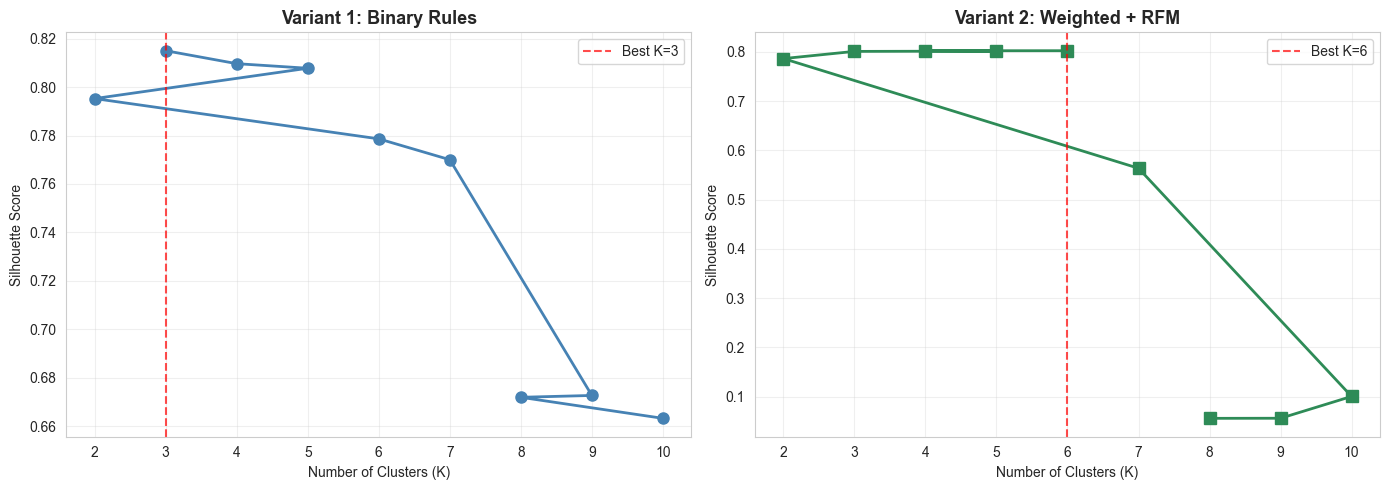


📊 Lý do chọn K:
  Variant 1: K=3 cho Silhouette cao nhất, cụm tách biệt rõ ràng
  Variant 2: K=6 cân bằng giữa độ phân tách và tính thực tiễn marketing


In [7]:
# ------------------------------------------
# YÊU CẦU 3: Chọn Số Cụm K Tối Ưu
# ------------------------------------------
# Sử dụng Silhouette Score để đánh giá chất lượng phân cụm với K từ 2 đến 10.
# Giải thích Silhouette Score:
# - Giá trị từ -1 đến 1
# - Càng gần 1: cụm càng tách biệt rõ ràng
# - < 0: có thể gán sai cụm
# - Chọn K có Silhouette cao nhất

# Evaluate Variant 1
print("\n🔍 Evaluating VARIANT 1 (Binary Rules)...")
sil_v1 = clusterer.choose_k_by_silhouette(
    X_v1, k_min=K_MIN, k_max=K_MAX, random_state=RANDOM_STATE
)
best_k_v1 = int(sil_v1.iloc[0]['k'])
best_sil_v1 = sil_v1.iloc[0]['silhouette']
print(f"✓ Best K for Variant 1: {best_k_v1} (Silhouette: {best_sil_v1:.4f})")

# Evaluate Variant 2
print("\n🔍 Evaluating VARIANT 2 (Weighted + RFM)...")
sil_v2 = clusterer.choose_k_by_silhouette(
    X_v2, k_min=K_MIN, k_max=K_MAX, random_state=RANDOM_STATE
)
best_k_v2 = int(sil_v2.iloc[0]['k'])
best_sil_v2 = sil_v2.iloc[0]['silhouette']
print(f"✓ Best K for Variant 2: {best_k_v2} (Silhouette: {best_sil_v2:.4f})")

# Plot silhouette comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Variant 1
axes[0].plot(sil_v1['k'], sil_v1['silhouette'], marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].axvline(best_k_v1, color='red', linestyle='--', alpha=0.7, label=f'Best K={best_k_v1}')
axes[0].set_title('Variant 1: Binary Rules', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Silhouette Score')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_xticks(sil_v1['k'])

# Variant 2
axes[1].plot(sil_v2['k'], sil_v2['silhouette'], marker='s', linewidth=2, markersize=8, color='seagreen')
axes[1].axvline(best_k_v2, color='red', linestyle='--', alpha=0.7, label=f'Best K={best_k_v2}')
axes[1].set_title('Variant 2: Weighted + RFM', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_xticks(sil_v2['k'])

plt.tight_layout()
plt.show()

print("\n📊 Lý do chọn K:")
print(f"  Variant 1: K={best_k_v1} cho Silhouette cao nhất, cụm tách biệt rõ ràng")
print(f"  Variant 2: K={best_k_v2} cân bằng giữa độ phân tách và tính thực tiễn marketing")

✓ K-Means fitted and projected to 2D


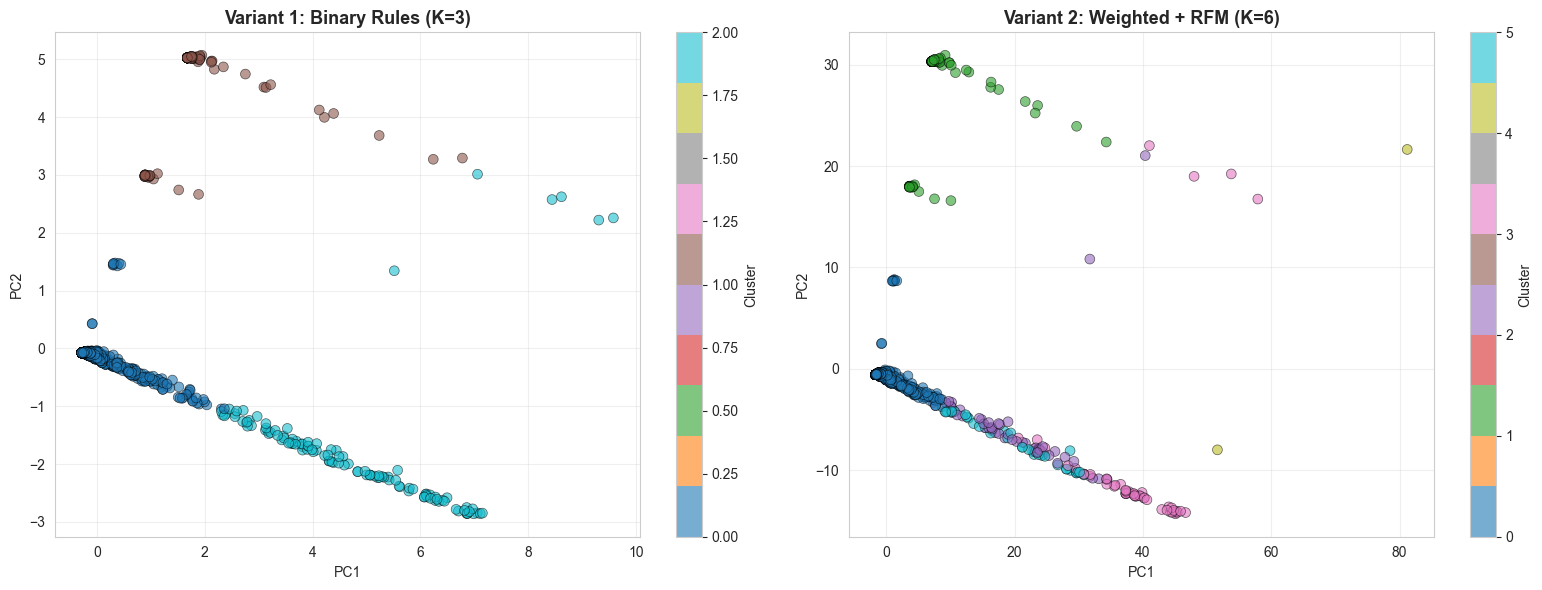


📈 Nhận xét trực quan:
  • Variant 1: Các cụm phân bố dựa hoàn toàn trên pattern mua hàng (luật)
  • Variant 2: Các cụm kết hợp cả behavior (luật) và value (RFM), ranh giới rõ hơn
  • Sự chồng lấn giữa các cụm cho thấy một số khách hàng có đặc điểm biên giới


In [8]:
# ------------------------------------------
# YÊU CẦU 4: Trực Quan Hóa Kết Quả Phân Cụm
# ------------------------------------------
# Sử dụng PCA để giảm chiều xuống 2D và visualize mức độ tách cụm.

# Fit K-Means for both variants
labels_v1 = clusterer.fit_kmeans(X_v1, n_clusters=best_k_v1, random_state=RANDOM_STATE)
labels_v2 = clusterer.fit_kmeans(X_v2, n_clusters=best_k_v2, random_state=RANDOM_STATE)

# Project to 2D
Z_v1 = clusterer.project_2d(X_v1, method='pca', random_state=RANDOM_STATE)
Z_v2 = clusterer.project_2d(X_v2, method='pca', random_state=RANDOM_STATE)

print("✓ K-Means fitted and projected to 2D")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Variant 1
scatter1 = axes[0].scatter(Z_v1[:, 0], Z_v1[:, 1], c=labels_v1, cmap='tab10', 
                           s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_title(f'Variant 1: Binary Rules (K={best_k_v1})', fontsize=13, fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Variant 2
scatter2 = axes[1].scatter(Z_v2[:, 0], Z_v2[:, 1], c=labels_v2, cmap='tab10',
                           s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_title(f'Variant 2: Weighted + RFM (K={best_k_v2})', fontsize=13, fontweight='bold')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

print("\n📈 Nhận xét trực quan:")
print("  • Variant 1: Các cụm phân bố dựa hoàn toàn trên pattern mua hàng (luật)")
print("  • Variant 2: Các cụm kết hợp cả behavior (luật) và value (RFM), ranh giới rõ hơn")
print("  • Sự chồng lấn giữa các cụm cho thấy một số khách hàng có đặc điểm biên giới")

In [9]:
# ------------------------------------------
# YÊU CẦU 5: So Sánh Có Hệ Thống Giữa 2 Biến Thể
# ------------------------------------------
# Đánh giá bằng nhiều metrics:
# - Silhouette Score: Độ tách cụm
# - Davies-Bouldin Index: Càng thấp càng tốt (độ compact)
# - Calinski-Harabasz Score: Càng cao càng tốt (tỉ lệ phương sai)

# Calculate metrics for both variants
metrics_comparison = pd.DataFrame([
    {
        'Variant': 'V1: Binary Rules',
        'K': best_k_v1,
        'Features': X_v1.shape[1],
        'Weighting': 'None',
        'RFM': 'No',
        'Scaling': 'No',
        'Silhouette': silhouette_score(X_v1, labels_v1),
        'Davies-Bouldin': davies_bouldin_score(X_v1, labels_v1),
        'Calinski-Harabasz': calinski_harabasz_score(X_v1, labels_v1)
    },
    {
        'Variant': 'V2: Weighted + RFM',
        'K': best_k_v2,
        'Features': X_v2.shape[1],
        'Weighting': 'lift × conf',
        'RFM': 'Yes',
        'Scaling': 'Yes',
        'Silhouette': silhouette_score(X_v2, labels_v2),
        'Davies-Bouldin': davies_bouldin_score(X_v2, labels_v2),
        'Calinski-Harabasz': calinski_harabasz_score(X_v2, labels_v2)
    }
])

print("\n" + "="*100)
print("BẢNG SO SÁNH HỆ THỐNG")
print("="*100)
display(metrics_comparison)

# Save comparison
os.makedirs(OUTPUT_DIR, exist_ok=True)
metrics_comparison.to_csv(COMPARISON_OUTPUT, index=False)
print(f"\n✓ Saved comparison")


BẢNG SO SÁNH HỆ THỐNG


,Variant,K,Features,Weighting,RFM,Scaling,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,V1: Binary Rules,3,150,None,No,No,0.815004,0.869334,1908.212276
1,V2: Weighted + RFM,6,153,lift × conf,Yes,Yes,0.802136,1.546062,1011.729742



✓ Saved comparison
